In [1]:
from importlib import reload  
import pandas as pd
import clintraj_qi
reload(clintraj_qi)

from clintraj_qi import quantify_nans
from clintraj_qi import detect_variable_type
from clintraj_qi import quantify_dataframe_univariate
from clintraj_qi import SVDcomplete_imputation_method
from clintraj_qi import load_quantification_info
from clintraj_qi import invert_quant_info
from clintraj_qi import dequantify_table


In [2]:
# loading the table

#file = 'data/diabetis/sample_1/diabetis.csv'
#df = pd.read_csv(file,delimiter=',')
#file = 'data/diabetis/diabetic_numerical_sample1.txt'
#file = 'data/diabetis/diabete_glr_sample.txt'
file = 'data/diabetis/diabete_glr.txt'
df = pd.read_csv(file,delimiter='\t')
display(df)

,encounter_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,age,...,diabetesMed_Yes,metformin_treatment,metformin_treatment_change,glipizide_treatment,glipizide_treatment_change,glyburide_treatment,glyburide_treatment_change,insulin_treatment,insulin_treatment_change,readmitted
0,2278392,1,41,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,149190,3,59,0,18,0,0,0,9,1,...,1,0,0,0,0,0,0,1,1,1
2,64410,2,11,5,13,2,0,1,6,2,...,1,0,0,1,0,0,0,0,0,0
3,500364,2,44,1,16,0,0,0,7,3,...,1,0,0,0,0,0,0,1,1,0
4,16680,1,51,0,8,0,0,0,5,4,...,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99338,443847548,3,51,0,16,0,0,0,9,7,...,1,1,0,0,0,0,0,1,-1,1
99339,443847782,5,33,3,18,0,0,1,9,8,...,1,0,0,0,0,0,0,1,0,0
99340,443854148,1,53,0,9,1,0,0,13,7,...,1,1,0,0,0,0,0,1,-1,0
99341,443857166,10,45,2,21,0,0,1,9,8,...,1,0,0,1,0,0,0,1,1,0


In [3]:
quantify_nans(df,file_to_write=file[:-4]+'_complete.txt')

Missing values 82509 (3.7752122352949793%)
Number of complete rows: 16834 (16.945330823510464%)


In [4]:
variable_types, binary, continuous, ordinal = detect_variable_type(df,5,verbose=False)
#correct_column_types_in_dataframe(df,variable_types)
#variable_types, binary, continuous, ordinal = detect_variable_type(df,10,verbose=True)
    
df[binary].to_csv(file[:-4]+'_binary.txt', index=False,sep='\t')
df[continuous].to_csv(file[:-4]+'_continuous.txt', index=False,sep='\t')
df[ordinal].to_csv(file[:-4]+'_ordinal.txt', index=False,sep='\t')

print(variable_types)

['CONTINUOUS', 'CONTINUOUS', 'CONTINUOUS', 'CONTINUOUS', 'CONTINUOUS', 'CONTINUOUS', 'CONTINUOUS', 'CONTINUOUS', 'CONTINUOUS', 'BINARY', 'ORDINAL', 'BINARY', 'BINARY', 'BINARY', 'ORDINAL', 'BINARY', 'ORDINAL', 'BINARY', 'ORDINAL', 'BINARY', 'ORDINAL', 'ORDINAL']


In [6]:
# analyzing correlations between all columns, in order to detect tightly correlated variables

corr_table = df.corr(method='spearman')
# display(corr_table)

# print strong variable correlations
correlation_threshold = 0.3

for v in corr_table.items():
    for val in v[1].items():
        corr = val[1]
        name = val[0]
        if not name==v[0]:
            if corr>=correlation_threshold:
                print(v[0]+'\t'+name+'\t'+str(corr))

time_in_hospital	num_lab_procedures	0.3389322804418158
time_in_hospital	num_medications	0.46344589830409116
num_lab_procedures	time_in_hospital	0.3389322804418158
num_procedures	num_medications	0.34861859256054656
num_medications	time_in_hospital	0.46344589830409116
num_medications	num_procedures	0.34861859256054656
change_Ch	diabetesMed_Yes	0.5055286573473068
change_Ch	metformin_treatment	0.3253143328839733
change_Ch	insulin_treatment	0.5139778871986337
diabetesMed_Yes	change_Ch	0.5055286573473068
diabetesMed_Yes	insulin_treatment	0.580313839190223
metformin_treatment	change_Ch	0.3253143328839733
insulin_treatment	change_Ch	0.5139778871986337
insulin_treatment	diabetesMed_Yes	0.580313839190223


In [7]:
# univariate table quantification
dfq,replacement_info = quantify_dataframe_univariate(df,variable_types)
#display(dfq)
#print(replacement_info)
with open(file[:-4]+'_norm_info.txt','w') as fid:
    fid.write(replacement_info)

/home/zinovyev/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/zinovyev/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


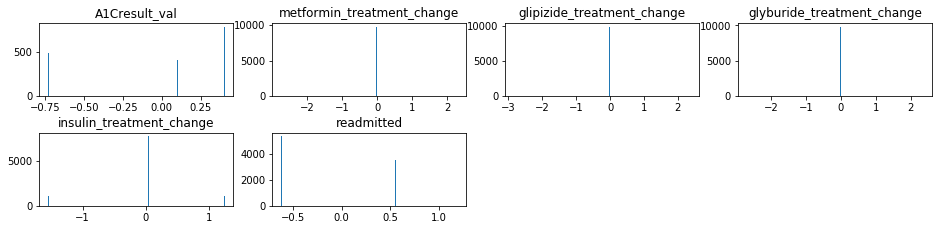

In [59]:
# univariate table quantification, check histograms for different variable types

import matplotlib.pyplot as plt

dframe = dfq

nbins = int(dframe.shape[0]/50)
#var_type = 'CONTINUOUS'
var_type = 'ORDINAL'
#var_type = 'BINARY'

ncont = variable_types.count(var_type)
plt.figure(figsize=(16,ncont/4*2))
plt.subplots_adjust(hspace=0.5,top=3)

k = 1
for i,v in enumerate(variable_types):
    if v==var_type:
        plt.subplot(ncont,4,k)
        col = dframe.columns[i+1]
        vals = dframe[col].to_numpy()
        plt.hist(vals,bins=nbins)
        plt.title(col)
        k = k+1


Matrix shape: (16834, 22)
Effective linear dimension 12
Full matrix shape (99343, 22)


,encounter_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,age,...,diabetesMed_Yes,metformin_treatment,metformin_treatment_change,glipizide_treatment,glipizide_treatment_change,glyburide_treatment,glyburide_treatment_change,insulin_treatment,insulin_treatment_change,readmitted
0,2278392,-1.138438,-0.097243,-0.783565,-1.850439,-0.291863,-0.211622,-0.500575,-3.298145,-3.809591,...,-0.355155,-0.218835,-0.008773,-0.164433,-0.003363,-0.146352,-0.003837,-0.343573,0.053812,-0.629299
1,149190,-0.464673,0.820659,-0.783565,0.249657,-0.291863,-0.211622,-0.500575,0.823436,-3.182439,...,0.104733,-0.218835,-0.008773,-0.164433,-0.003363,-0.146352,-0.003837,0.300857,1.265554,0.546511
2,64410,-0.801555,-1.627080,2.152815,-0.368019,1.288995,-0.211622,0.292810,-0.722157,-2.555287,...,0.104733,-0.218835,-0.008773,1.139158,-0.003363,-0.146352,-0.003837,-0.343573,0.053812,-0.629299
3,500364,-0.801555,0.055741,-0.196289,0.002587,-0.291863,-0.211622,-0.500575,-0.206960,-1.928135,...,0.104733,-0.218835,-0.008773,-0.164433,-0.003363,-0.146352,-0.003837,0.300857,1.265554,-0.629299
4,16680,-1.138438,0.412703,-0.783565,-0.985694,-0.291863,-0.211622,-0.500575,-1.237355,-1.300982,...,0.104733,-0.218835,-0.008773,1.139158,-0.003363,-0.146352,-0.003837,0.300857,0.053812,-0.629299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99338,443847548,-0.464673,0.412703,-0.783565,0.002587,-0.291863,-0.211622,-0.500575,0.823436,0.580474,...,0.104733,0.876697,-0.008773,-0.164433,-0.003363,-0.146352,-0.003837,0.300857,-1.513138,0.546511
99339,443847782,0.209092,-0.505200,0.978263,0.249657,-0.291863,-0.211622,0.292810,0.823436,1.207626,...,0.104733,-0.218835,-0.008773,-0.164433,-0.003363,-0.146352,-0.003837,0.300857,0.053812,-0.629299
99340,443854148,-1.138438,0.514692,-0.783565,-0.862159,0.498566,-0.211622,-0.500575,2.884226,0.580474,...,0.104733,0.876697,-0.008773,-0.164433,-0.003363,-0.146352,-0.003837,0.300857,-1.513138,-0.629299
99341,443857166,1.893505,0.106735,0.390987,0.620262,-0.291863,-0.211622,0.292810,0.823436,1.207626,...,0.104733,-0.218835,-0.008773,1.139158,-0.003363,-0.146352,-0.003837,0.300857,1.265554,-0.629299


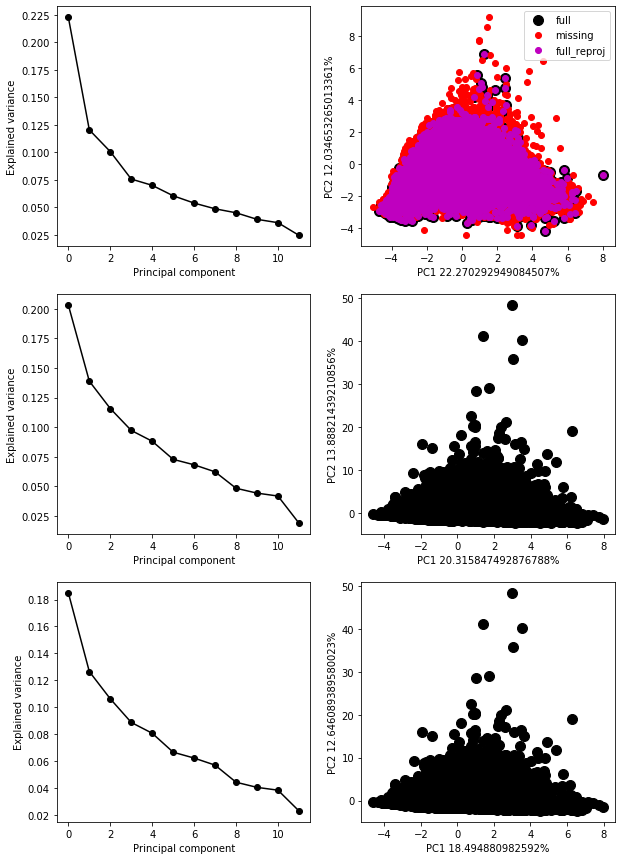

In [67]:
dfq_imputed = SVDcomplete_imputation_method(dfq, variable_types, verbose=True,num_components=-1)
display(dfq_imputed)

In [68]:
# saving the quantified and imputed file
#display(dfq_imputed)
dfq_imputed.round(3).to_csv(file[:-4]+'_q_imp_SVDcomplete.txt',index=False,sep='\t')

# saving the de-quantified imputed file
dequant_info = invert_quant_info(load_quantification_info(file[:-4]+'_norm_info.txt'))
#print(dequant_info)

df_imputed = dequantify_table(dfq_imputed,dequant_info)
#display(df_imputed)

df_imputed.to_csv(file[:-4]+'_imp_SVDcomplete.txt',index=False,sep='\t')